### sentinel-3 altimetry data processing 

In [3]:
import numpy as np
import xarray as xr
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from utils.functions import meter2deg
from utils.functions import sample_from_raster, hz01_hz20


In [4]:
lake_name = 'siling_co'
path_ht_spavar = f'data/{lake_name}-lake/swot-pixc/raster_height_spavar.nc'
path_lake_vec = f'data/{lake_name}-lake/hydrolake_{lake_name}.gpkg'
paths_s3 = glob(f'data/{lake_name}-lake/s3/*/standard_measurement.nc')
path_s3 = paths_s3[0]


In [5]:
## read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)
# ## read geoid correction file
raster_geoid_cor = xr.open_dataset(path_ht_spavar) 
raster_geoid_cor 
## read s3 altimetry data
s3_xr = xr.open_dataset(path_s3)
s3_xr


<xarray.Dataset> Size: 33MB
Dimensions:                                        (time_01: 1728,
                                                    time_20_ku: 34591,
                                                    time_20_c: 33840)
Coordinates:
  * time_01                                        (time_01) datetime64[ns] 14kB ...
  * time_20_ku                                     (time_20_ku) datetime64[ns] 277kB ...
  * time_20_c                                      (time_20_c) datetime64[ns] 271kB ...
    lat_01                                         (time_01) float64 14kB ...
    lon_01                                         (time_01) float64 14kB ...
    lat_20_ku                                      (time_20_ku) float64 277kB ...
    lon_20_ku                                      (time_20_ku) float64 277kB ...
    lat_20_c                                       (time_20_c) float64 271kB ...
    lon_20_c                                       (time_20_c) float64 271kB ...
Data variables: (12/275)
    UTC_day_01                                     (time_01) datetime64[ns] 14kB ...
    UTC_sec_01                                     (time_01) float64 14kB ...
    UTC_day_20_ku                                  (time_20_ku) datetime64[ns] 277kB ...
    UTC_sec_20_ku                                  (time_20_ku) float64 277kB ...
    UTC_day_20_c                                   (time_20_c) datetime64[ns] 271kB ...
    UTC_sec_20_c                                   (time_20_c) float64 271kB ...
    ...                                             ...
    num_20hz_meas_01_ku                            (time_01) float32 7kB ...
    num_20hz_meas_01_c                             (time_01) float32 7kB ...
    orbit_type_01                                  (time_01) float32 7kB ...
    waveform_qual_ice_20_ku                        (time_20_ku) float32 138kB ...
    iono_cor_alt_filtered_01_ku                    (time_01) float64 14kB ...
    iono_cor_alt_filtered_01_plrm_ku               (time_01) float64 14kB ...
Attributes: (12/45)
    Conventions:                       CF-1.6
    title:                             IPF SRAL/MWR Level 2 Measurement
    mission_name:                      Sentinel 3B
    altimeter_sensor_name:             SRAL
    radiometer_sensor_name:            MWR
    gnss_sensor_name:                  GNSS
    ...                                ...
    xref_iono_data:                    S3B_SR_2_RGI_AX_20230728T000000_202307...
    xref_mog2d_data:                   S3__SR_2_RMO_AX_20230728T000000_202307...
    xref_seaice_concentration:         S3__SR_2_SIC_AX_20230728T000000_202307...
    xref_altimeter_ltm:                S3B_SR_1_CA1LAX_20000101T000000_202308...
    xref_doris_uso:                    S3B_SR_1_USO_AX_20180501T144459_202308...
    xref_time_correlation:             S3B_AX___FRO_AX_20230728T000000_202308...

In [6]:
## create a interior buffered lake vector
lake_decrease_gdf = lake_gdf.copy()
lon_center = lake_decrease_gdf.bounds.mean(axis=1).values
utm_zone = np.floor(lon_center/6)+31
epsg_code = f'326{int(utm_zone[0])}'
lake_decrease_gdf = lake_decrease_gdf.to_crs(epsg=epsg_code)
lake_decrease_gdf['geometry'] = lake_decrease_gdf.geometry.buffer(-1000)
lake_decrease_gdf = lake_decrease_gdf.to_crs(epsg=4326)
## select the data within the lake area
points = [Point(lon, lat) for lon, lat in zip(s3_xr['lon_cor_20_ku'].values, s3_xr['lat_cor_20_ku'].values)]
ids_valid_s3 = np.where(lake_decrease_gdf.geometry[0].contains(points))[0]
s3_xr_mask = s3_xr.isel({'time_20_ku': ids_valid_s3})
s3_xr_mask


<xarray.Dataset> Size: 18MB
Dimensions:                                        (time_01: 1728,
                                                    time_20_ku: 107,
                                                    time_20_c: 33840)
Coordinates:
  * time_01                                        (time_01) datetime64[ns] 14kB ...
  * time_20_ku                                     (time_20_ku) datetime64[ns] 856B ...
  * time_20_c                                      (time_20_c) datetime64[ns] 271kB ...
    lat_01                                         (time_01) float64 14kB ...
    lon_01                                         (time_01) float64 14kB ...
    lat_20_ku                                      (time_20_ku) float64 856B ...
    lon_20_ku                                      (time_20_ku) float64 856B ...
    lat_20_c                                       (time_20_c) float64 271kB ...
    lon_20_c                                       (time_20_c) float64 271kB ...
Data variables: (12/275)
    UTC_day_01                                     (time_01) datetime64[ns] 14kB ...
    UTC_sec_01                                     (time_01) float64 14kB ...
    UTC_day_20_ku                                  (time_20_ku) datetime64[ns] 856B ...
    UTC_sec_20_ku                                  (time_20_ku) float64 856B ...
    UTC_day_20_c                                   (time_20_c) datetime64[ns] 271kB ...
    UTC_sec_20_c                                   (time_20_c) float64 271kB ...
    ...                                             ...
    num_20hz_meas_01_ku                            (time_01) float32 7kB ...
    num_20hz_meas_01_c                             (time_01) float32 7kB ...
    orbit_type_01                                  (time_01) float32 7kB ...
    waveform_qual_ice_20_ku                        (time_20_ku) float32 428B ...
    iono_cor_alt_filtered_01_ku                    (time_01) float64 14kB ...
    iono_cor_alt_filtered_01_plrm_ku               (time_01) float64 14kB ...
Attributes: (12/45)
    Conventions:                       CF-1.6
    title:                             IPF SRAL/MWR Level 2 Measurement
    mission_name:                      Sentinel 3B
    altimeter_sensor_name:             SRAL
    radiometer_sensor_name:            MWR
    gnss_sensor_name:                  GNSS
    ...                                ...
    xref_iono_data:                    S3B_SR_2_RGI_AX_20230728T000000_202307...
    xref_mog2d_data:                   S3__SR_2_RMO_AX_20230728T000000_202307...
    xref_seaice_concentration:         S3__SR_2_SIC_AX_20230728T000000_202307...
    xref_altimeter_ltm:                S3B_SR_1_CA1LAX_20000101T000000_202308...
    xref_doris_uso:                    S3B_SR_1_USO_AX_20180501T144459_202308...
    xref_time_correlation:             S3B_AX___FRO_AX_20230728T000000_202308...

In [16]:
## 1. geophysical correction by refering to official document.
geo_corr_01hz=['mod_dry_tropo_cor_meas_altitude_01', 'mod_wet_tropo_cor_meas_altitude_01', 
                                        'iono_cor_gim_01_ku', 'load_tide_sol1_01', 
                                        'solid_earth_tide_01', 'pole_tide_01']
s3_geophy_01hz = 0
for cor_01hz_name in geo_corr_01hz:
  s3_geophy_01hz += s3_xr_mask[cor_01hz_name].values

## 2. Resample the 1Hz variables to 20Hz variables
times_20, times_01 = s3_xr_mask['time_20_ku'].values, s3_xr_mask['time_01'].values
s3_geophy_20hz = hz01_hz20(data_01hz=s3_geophy_01hz, time_01hz=times_01, time_20hz=times_20)
## 3. Calculate the corrected surface water height
## 3.1 ocog/ocean retracker
height_ocog = s3_xr_mask['alt_20_ku'].values - s3_xr_mask['range_ocog_20_ku'].values - s3_geophy_20hz ## height_ellip
print(f'S3 height_ortho_cor std: {np.nanstd(height_ocog):.3f} m')


S3 height_ortho_cor std: 0.384 m


In [17]:
## remove outliers
height_ocog_median = np.median(height_ocog)
height_ocog = np.where((height_ocog > height_ocog_median - 0.3) & 
                            (height_ocog < height_ocog_median + 0.3), height_ocog, np.nan)
print(f'S3 height_ortho_cor std: {np.nanstd(height_ocog):.3f} m')


S3 height_ortho_cor std: 0.140 m


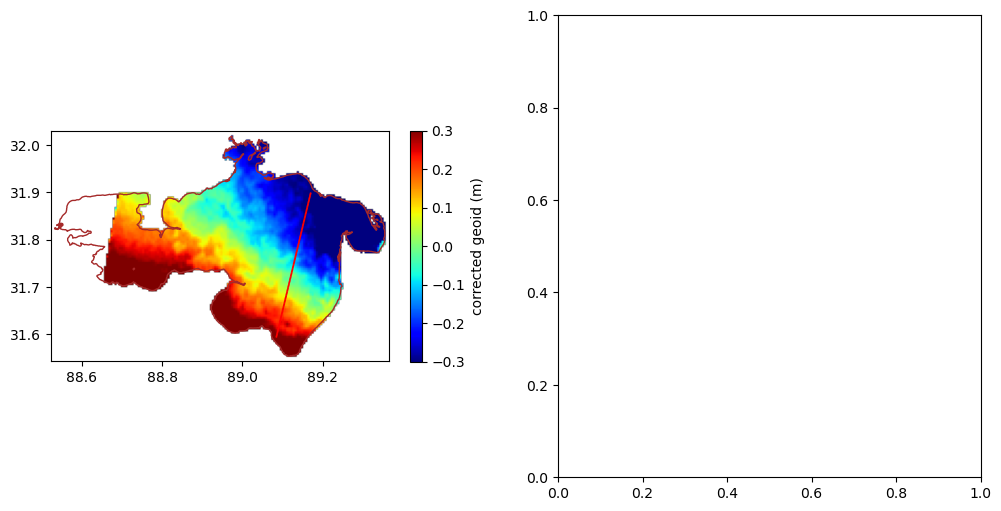

In [18]:
extent_raster = [raster_geoid_cor.x.min(), raster_geoid_cor.x.max(),
           raster_geoid_cor.y.min(), raster_geoid_cor.y.max()]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
geoid_mean = np.nanmean(raster_geoid_cor.ht_spavar_smoothed.values)
img_show1 = ax[0].imshow(raster_geoid_cor.ht_spavar_smoothed.values, cmap='jet', 
                        vmin = geoid_mean-0.3, vmax = geoid_mean+0.3, extent=extent_raster)
lake_gdf.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)
scat1 = ax[0].scatter(x=s3_xr_mask['lon_20_ku'].values, y=s3_xr_mask['lat_20_ku'].values,
                      c='red', s=2, edgecolor='none')
plt.colorbar(img_show1, ax=ax[0], label='corrected geoid (m)', shrink=0.5)


In [19]:
## geoid correction
## sample the geoid correction raster to the S3 points
s3_ht_spahet = sample_from_raster(
        raster_value=raster_geoid_cor.ht_spavar_smoothed.values,
        raster_x = raster_geoid_cor.x.values,
        raster_y = raster_geoid_cor.y.values,
        points_x = s3_xr_mask['lon_20_ku'],
        points_y = s3_xr_mask['lat_20_ku']
)

s3_ht_spahet = s3_ht_spahet - np.nanmean(s3_ht_spahet)  ## remove the mean value
s3_geoid_20hz = hz01_hz20(data_01hz=s3_xr_mask['geoid_01'].values, time_01hz=times_01, time_20hz=times_20)
s3_ht_ortho = height_ocog - s3_geoid_20hz  ## 
s3_geoid_cor = np.nanmean(s3_geoid_20hz) + s3_ht_spahet
s3_ht_ortho_cor = height_ocog - s3_geoid_cor


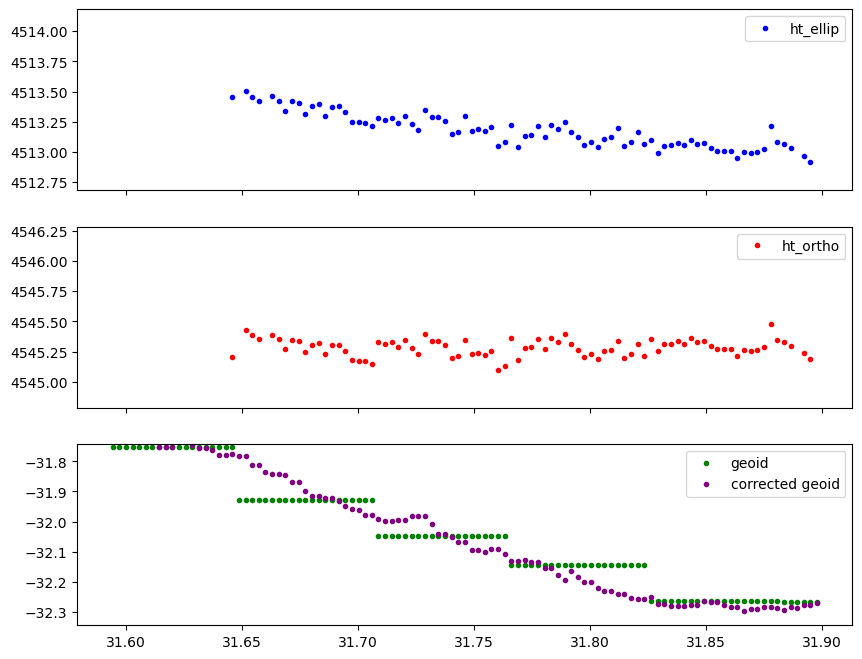

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
## plot height_ellip
ht_mean = np.nanmean(height_ocog)
ax[0].plot(s3_xr_mask['lat_20_ku'], height_ocog, 
         marker='o', markersize=3, linestyle='None', 
         color='blue', label='ht_ellip')
ax[0].set_ylim(ht_mean - 0.5, ht_mean + 1)
ax[0].legend()
## plot height_ortho
ht_ortho_mean = np.nanmean(s3_ht_ortho)
ax[1].plot(s3_xr_mask['lat_20_ku'], s3_ht_ortho, 
         marker='o', markersize=3, linestyle='None', 
         color='red', label='ht_ortho')
ax[1].set_ylim(ht_ortho_mean - 0.5, ht_ortho_mean + 1)
ax[1].legend()
## plot geoid
s3_geoid_mean = np.nanmean(s3_geoid_20hz)
ax[2].plot(s3_xr_mask['lat_20_ku'], s3_geoid_20hz, 
         marker='o', markersize=3, linestyle='None', 
         color='green', label='geoid')
ax[2].set_ylim(s3_geoid_mean - 0.3, s3_geoid_mean + 0.3)
## plot corrected geoid
s3_geoid_cor_mean = np.nanmean(s3_geoid_cor)
ax[2].plot(s3_xr_mask['lat_20_ku'], s3_geoid_cor,
         marker='o', markersize=3, linestyle='None', 
         color='purple', label='corrected geoid')
ax[2].set_ylim(s3_geoid_cor_mean - 0.3, s3_geoid_cor_mean + 0.3)
ax[2].legend()


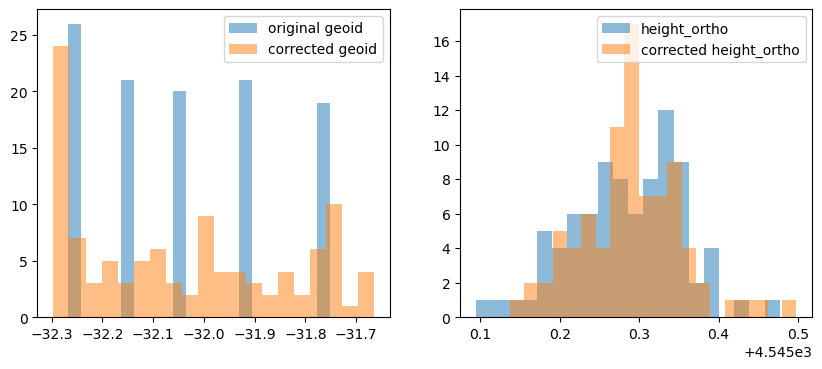

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(s3_geoid_20hz, bins=20, alpha=0.5, label='original geoid');
ax[0].hist(s3_geoid_cor.ravel(), bins=20, alpha=0.5, label='corrected geoid');
ax[0].legend();
ax[1].hist(s3_ht_ortho, bins=20, alpha=0.5, label='height_ortho');
ax[1].hist(s3_ht_ortho_cor, bins=20, alpha=0.5, label='corrected height_ortho');
ax[1].legend();


In [22]:
s3_ht_ds = xr.Dataset({
  "geoid": (["time_20_ku"], s3_geoid_20hz),
  "geoid_cor": (["time_20_ku"], s3_geoid_cor),  
  "ht_ortho": (["time_20_ku"], s3_ht_ortho),
  "ht_ortho_cor": (["time_20_ku"], s3_ht_ortho_cor)
}, coords={
  "time_20_ku": s3_xr_mask["time_20_ku"],
  "lon_20_ku": s3_xr_mask["lon_20_ku"],
  "lat_20_ku": s3_xr_mask["lat_20_ku"]
})

path_save = path_s3.replace('.h5', '_height.nc')
# s3_ht_ds.to_netcdf(path_save)
s3_ht_ds


<xarray.Dataset> Size: 6kB
Dimensions:       (time_20_ku: 107)
Coordinates:
  * time_20_ku    (time_20_ku) datetime64[ns] 856B 2023-07-28T04:25:23.248264...
    lat_20_ku     (time_20_ku) float64 856B 31.9 31.9 31.89 ... 31.6 31.6 31.59
    lon_20_ku     (time_20_ku) float64 856B 89.17 89.17 89.17 ... 89.09 89.08
Data variables:
    geoid         (time_20_ku) float64 856B -32.27 -32.27 ... -31.75 -31.75
    geoid_cor     (time_20_ku) float64 856B -32.27 -32.27 ... -31.68 -31.67
    ht_ortho      (time_20_ku) float64 856B nan 4.545e+03 4.545e+03 ... nan nan
    ht_ortho_cor  (time_20_ku) float64 856B nan 4.545e+03 4.545e+03 ... nan nan

In [23]:
print('std of geoid height:          ', np.nanstd(s3_ht_ds['ht_ortho']))
print('std of geoid height corrected:', np.nanstd(s3_ht_ds['ht_ortho_cor']))


std of geoid height:           0.06980592119776692
std of geoid height corrected: 0.0634985828360488


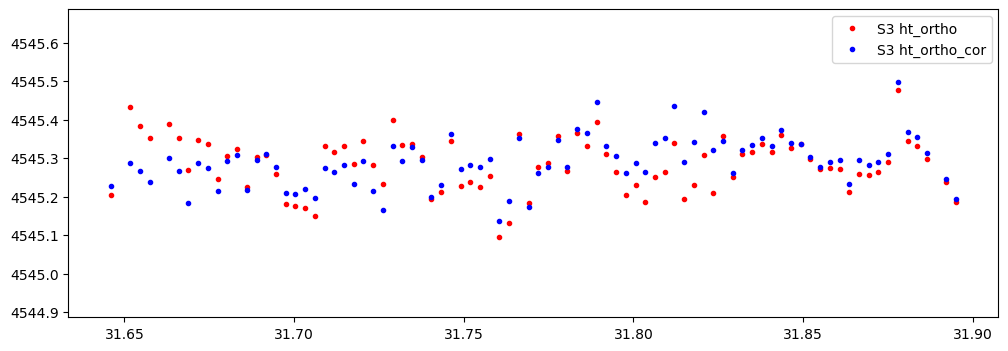

In [24]:
height_geoid_median = np.nanmedian(s3_ht_ds['ht_ortho'])
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(s3_xr_mask['lat_20_ku'], s3_ht_ds['ht_ortho'], 
                  marker='o', markersize=3, linestyle='None', 
                  color='red', label='S3 ht_ortho')

ax.plot(s3_xr_mask['lat_20_ku'], s3_ht_ds['ht_ortho_cor'], 
                  marker='o', markersize=3, linestyle='None', 
                  color='blue', label='S3 ht_ortho_cor')
ax.set_ylim(height_geoid_median-0.4, height_geoid_median+0.4)
ax.legend()
